In [172]:
# -------- Imports --------
import sys
import os
import numpy as np
import scipy.sparse as sp
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from _utility import *

# -- Qiskit imports --
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import MatrixExponential
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator
from qiskit.primitives import StatevectorEstimator

np.random.seed(0)


In [173]:
# -------- Parameters --------
# -- Grid parameters --
Nx, Ny  = 4, 4
dx, dy = 1.0, 1.0
psi_len = Nx*Ny + (Nx-1)*Ny + Nx*(Ny-1) # Number of values for the staggered grid

# -- Simulation parameters --
t = 5.0

# -- Subspace projector --
mask = np.random.choice([0, 1], size=psi_len, p=[0.9, 0.1])


In [174]:
# Important: The following implementation of the material parameters is not scalable. This code is only for demonstration purposes and assumes oracle access. 
# In a real-world scenario, the material parameters and the Hamiltonian need to be sparsly constructed on the QC itself.
# Furthermore, this code uses direct matrix exponentiation, which is inefficient for large matrices. Other integration methods should be used (e.g. Trotter-Suzuki, Qubitization).

# -- Material properties (Oracle Access) -- 
# Velocity (c)
c0 = 3
c_model = c0 * np.ones((Ny, Nx))

# Density (rho)
rho0 = 2
rho_model = rho0 * np.ones((Ny, Nx))
rho_stag_x = rho0 * np.ones((Ny, (Nx-1)))
rho_stag_y = rho0 * np.ones(((Ny-1), Nx))

# -------- Simulation (2D Acoustic) (Oracle Access) --------
(H, A, _, B_sqrt, B_inv, _) = FD_solver_2D_quantum(Nx, Ny, dx, dy, c_model, rho_model, rho_stag_x, rho_stag_y)
H_pauli = SparsePauliOp.from_operator(Operator(H.toarray())) # Expensive conversion
print("Hamiltonian shape: ", H.shape)
print("Hamiltonian NNZ-Ratio: ", H.nnz/H.shape[0]**2)
print("Pauli Terms (inefficient representation): ", len(H_pauli))

# Number of grid points
N = Nx*Ny
print("Number of grid points: ", N)

# Number of qubits
n = (H.shape[0]-1).bit_length()
print("Number of qubits (for wave field): ", n)


Hamiltonian shape:  (64, 64)
Hamiltonian NNZ-Ratio:  0.0234375
Pauli Terms (inefficient representation):  340
Number of grid points:  16
Number of qubits (for wave field):  6


In [175]:
# -- Initial Conditions --
# Pressure field (u)
f0 = 2.0            # Central frequency of the Ricker wavelet
x0, y0 = 0.0, 0.0   # Wavelet center
X, Y = np.meshgrid(np.linspace(-1, 1, Nx), np.linspace(-1, 1, Ny))
u0 = sp.csr_array(np.round(Ricker(f0, X, Y, 0, x0/Nx, y0/Ny), 20))

# Particle velocity field x (vx)
v0x = sp.csr_array((Ny, (Nx-1)))

# Particle velocity field y (vy)
v0y = sp.csr_array(((Ny-1), Nx))

# Stack the initial conditions
phi_0 = sp.vstack([u0.reshape(-1, 1), v0x.reshape(-1, 1), v0y.reshape(-1, 1)])

# Pad the initial conditions with zeros
phi_0 = sp.vstack([phi_0, sp.csr_matrix((H.shape[0]- psi_len, 1))]).toarray().flatten()

# Normalize the initial state and transform it to the energy basis
psi_0 = B_sqrt @ phi_0
norm = np.linalg.norm(psi_0)
psi_0 /= norm

# Number of non-zero initial state values
psi_0_nnz = np.sum(psi_0 != 0)
print('Initial state NNZ-Ratio:', psi_0_nnz/psi_len)

# Pad the mask with zeros
mask = np.concatenate([mask, np.zeros(H.shape[0]-psi_len)])


Initial state NNZ-Ratio: 0.3


Observable Pauli terms:  2


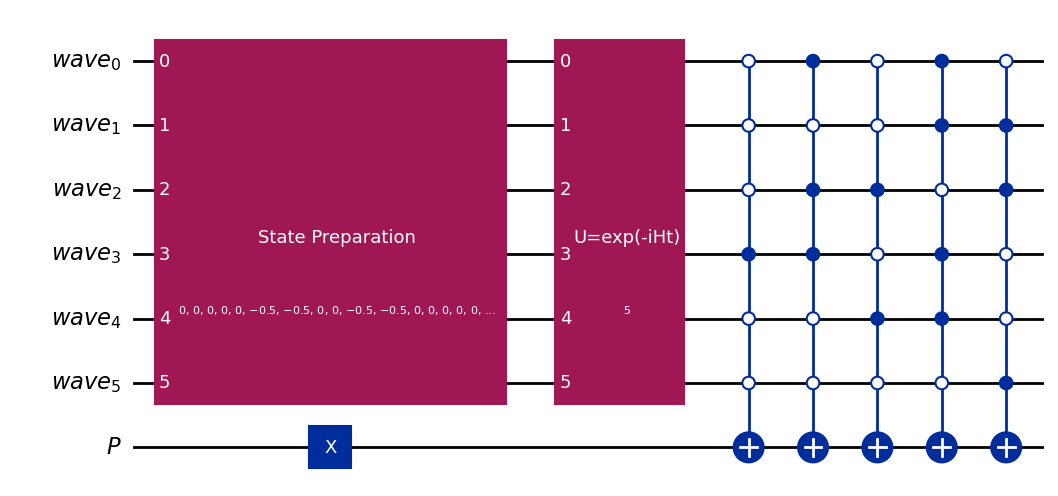

In [181]:
# -------- Quantum Circuit --------
# -- Time-evolution Synthesis --
synthesis = MatrixExponential()
evo = PauliEvolutionGate(H_pauli, time=t, synthesis=synthesis, label='U=exp(-iHt)')

# -- Quantum Simulation --
# Define the quantum registers
reg_wave = QuantumRegister(n, 'wave')
reg_P = QuantumRegister(1, 'P')

# Initialize the quantum circuit
qc = QuantumCircuit(reg_wave, reg_P)
qc.prepare_state(psi_0, reg_wave)

# Apply the time-evolution operator
qc.append(evo, reg_wave)

# Apply unitary "projection" transform (Can often be combined into fewer MCX gates)
qc.x(reg_P)
for d in np.nonzero(mask)[0]:
    qc.mcx(reg_wave, target_qubit=reg_P, ctrl_state=int(d))

# Define observable
O1 = Pauli('I'*(n+1))
O2 = Pauli('Z'+'I'*n)
observable = SparsePauliOp([O1, O2], [0.5, 0.5])
print("Observable Pauli terms: ", len(observable))

# Draw the circuit
qc.draw('mpl')


In [177]:
# -------- Simulation --------
# Simulate the quantum circuit
estimator = StatevectorEstimator()
job = estimator.run([(qc, observable)], precision=1e-8)
result = job.result()
print(f" > Expectation value: {result[0].data.evs}")
print(f" > Metadata: {result[0].metadata}")


 > Expectation value: 0.08364347831058884
 > Metadata: {'target_precision': 1e-08, 'circuit_metadata': {}}


In [178]:
# Compute the energy loss (post-processing)
E = result[0].data.evs
EN_QC = (1/2) * E * norm**2 * (dx * dy)
print('Subspace Energy Estimate (quantum):', EN_QC.round(10))


Subspace Energy Estimate (quantum): 6.1e-08


In [179]:
# Time Integration (Has classical integration errors (DOP853))
phi_t = solve_ivp(lambda t, phi: (B_inv @ A @ phi), (0, t), phi_0, t_eval=(0,t), method='DOP853').y.T[-1] 
EN_CL = (1/2) * np.linalg.norm(np.diag(mask) @ (B_sqrt @ phi_t), axis=0)**2 * (dx * dy)
print('Subspace Energy Estimate (classical):', EN_CL.round(10))


Subspace Energy Estimate (classical): 6.06e-08
